Name - Arnab Roy 

Student ID - C00246500

Date - 24.04.2020

## MSc in Data Science - Data Analytics and Algorithms Assessment

# Clustering, Visualization and Classification of United States Weather Events


Here, we will be looking into a weather event dataset with more than 5million events from 2016-2019 which covers 49 states of the United States of America.

The weather event types in the dataset are Cold, Fog, Snow, Rain, Hail and Storm.

The dataset is downloaded from the weblink https://smoosavi.org/datasets/lstw . 

On the basis of our types,

1. We will prepeare clusters on state and city wide distribution to determine which weather event affects which cluster the most. 

2. We are going to use Principal Component Analysis in order to visualise high dimensional data, so that, we can see how our clusters are related in the original space.

3. We will use various classificaion technique to check which factor plays an important role to classify weather event for Detroit City.

### Importing the required libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

In [3]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Load Dataset

### First, we take a quick look into our data in order to understand what we are working with and we clean/filter it. 

In [4]:
## loading the data

data = pd.read_csv('D:/weather data/WeatherEvents_Aug16_Dec19_Publish.csv')

In [5]:
## first 3 lines of data

data.head(3)

EventId  Type Severity       StartTime(UTC)         EndTime(UTC)  \
0   W-307  Rain    Light  2016-08-01 00:16:00  2016-08-01 00:56:00   
1   W-308  Rain    Light  2016-08-01 01:16:00  2016-08-01 01:36:00   
2   W-309  Rain    Light  2016-08-01 01:56:00  2016-08-01 02:16:00   

      TimeZone  LocationLat  LocationLng AirportCode      City    County  \
0  US/Mountain      38.0972    -106.1689        K04V  Saguache  Saguache   
1  US/Mountain      38.0972    -106.1689        K04V  Saguache  Saguache   
2  US/Mountain      38.0972    -106.1689        K04V  Saguache  Saguache   

  State  ZipCode  
0    CO  81149.0  
1    CO  81149.0  
2    CO  81149.0

In [6]:
## information regarding the data

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4362031 entries, 0 to 4362030
Data columns (total 13 columns):
EventId           object
Type              object
Severity          object
StartTime(UTC)    object
EndTime(UTC)      object
TimeZone          object
LocationLat       float64
LocationLng       float64
AirportCode       object
City              object
County            object
State             object
ZipCode           float64
dtypes: float64(3), object(10)
memory usage: 432.6+ MB


In [7]:
## 'Type' count

data['Type'].value_counts()

Rain             2636196
Fog               940916
Snow              575425
Cold              119736
Precipitation      59980
Storm              27579
Hail                2199
Name: Type, dtype: int64

In [8]:
## 'Severity' count

data['Severity'].value_counts()

Light       2679115
Severe       776955
Moderate     726549
Heavy        117233
UNK           59980
Other          2199
Name: Severity, dtype: int64

In [9]:
## checking the data size

data.size

56706403

### Duration of weather event was the key feature used to cluster regions. It was calculated by using event end time minus start time, any single event that lasted more than 30 days was initially eliminated, then any events outside three standard deviation away from mean were also removed.

In [10]:
## calculating duration

datetimeFormat = '%Y-%m-%d %H:%M:%S'
data['End']=pd.to_datetime(data['EndTime(UTC)'], format=datetimeFormat)
data['Start']=pd.to_datetime(data['StartTime(UTC)'], format=datetimeFormat)
data['Duration']=data['End']-data['Start']
data['Duration'] = data['Duration'].dt.total_seconds()
data['Duration'] = data['Duration']/(60*60) #in hours
data = data[(data['Duration']< 30*24) & (data['Duration'] != 0)] #remove obvious wrong data because hours can't be more than 24 and equal to 0
data.tail(3)

EventId  Type  Severity       StartTime(UTC)         EndTime(UTC)  \
4362028  W-4944437   Fog  Moderate  2019-12-28 12:53:00  2019-12-28 13:35:00   
4362029  W-4944438  Snow     Light  2019-12-28 13:35:00  2019-12-28 17:04:00   
4362030  W-4944439  Snow     Light  2019-12-28 17:15:00  2019-12-28 17:53:00   

            TimeZone  LocationLat  LocationLng AirportCode    City   County  \
4362028  US/Mountain      42.5833    -108.2833        KBVR  Lander  Fremont   
4362029  US/Mountain      42.5833    -108.2833        KBVR  Lander  Fremont   
4362030  US/Mountain      42.5833    -108.2833        KBVR  Lander  Fremont   

        State  ZipCode                 End               Start  Duration  
4362028    WY  82520.0 2019-12-28 13:35:00 2019-12-28 12:53:00  0.700000  
4362029    WY  82520.0 2019-12-28 17:04:00 2019-12-28 13:35:00  3.483333  
4362030    WY  82520.0 2019-12-28 17:53:00 2019-12-28 17:15:00  0.633333

### Event distribution

In [11]:
print("Overall Duration Summary")
print("--Count", data['Duration'].size)
print("--%miss.", sum(data['Duration'].isnull()))
print("--unique.",data['Duration'].unique().size)
print("--min",data['Duration'].min())
print("--mean",data['Duration'].mean())
print("--median",data['Duration'].median())
print("--max",data['Duration'].max())
print("--Std.Dev",data['Duration'].std())

Overall Duration Summary
--Count 4361859
--%miss. 0
--unique. 3415
--min 0.01666666666666667
--mean 1.3193150863683856
--median 0.6666666666666666
--max 718.6666666666666
--Std.Dev 4.4074922515868735


In [12]:
## ignoring the duration value more than 10 and checking the size.

data = data[(data['Duration']< 10)]
data['Duration'].size

4313441

### Creating a new dataset for better comparison of weather events, then all the duration time of them were normalized to the range 0 to 100, zero means that event never happened in the year and 100 means that event happened all the time during the year.

In [13]:
data2 = data.groupby(['AirportCode','City','State', 
                  'LocationLat', 'LocationLng','Type']).agg({'Duration':['sum']}).reset_index()
data2.columns=pd.MultiIndex.from_tuples((("AirportCode", " "),("City", " "),
                                       ("State", " "), ("LocationLat", " "),
                                       ("LocationLng", " "), ("Type", " "), ("Duration", " ")))
data2.columns = data2.columns.get_level_values(0)
data2['Duration'] = data2['Duration']/(24*4*3.65) #yearly percentage for 4 years from 2016-2019 
data2 = data2.sort_values(by='Duration')
data2.tail(3)

AirportCode       City State  LocationLat  LocationLng  Type   Duration
1735         KBOK  Brookings    OR      42.0744    -124.2900  Rain  12.077245
1076         KAST  Warrenton    OR      46.1569    -123.8825  Rain  12.216990
10901        KUIL      Forks    WA      47.9375    -124.5550  Rain  13.986777

In [14]:
df_new = data2.pivot(index='AirportCode', columns='Type', values=['Duration']).reset_index().fillna(0)
df_new.columns=pd.MultiIndex.from_tuples(((' ', 'AirportCode'),(' ', 'Cold'),(' ', 'Fog'),
            (' ',  'Hail'),(' ', 'Precipitation'),(' ', 'Rain'),(' ', 'Snow'),(' ', 'Storm')))
df_new.columns = df_new.columns.get_level_values(1)
df_new.tail(3)

AirportCode      Cold       Fog      Hail  Precipitation      Rain  \
2061        KYNG  0.019692  2.106640  0.016553       0.054842  8.268931   
2062        KZPH  0.207382  1.644787  0.000000       0.033295  3.790906   
2063        KZZV  0.005708  1.601979  0.000000       0.051275  5.379947   

          Snow     Storm  
2061  3.598935  0.000238  
2062  0.000000  0.001903  
2063  1.415573  0.000000

In [15]:
uniqueKey = data2[['AirportCode', 'City', 
                 'State', 'LocationLat', 'LocationLng']].sort_values(by='AirportCode').drop_duplicates()
weather = pd.merge(df_new, uniqueKey, how='inner', on='AirportCode')
weather.tail(3)

AirportCode      Cold       Fog      Hail  Precipitation      Rain  \
2061        KYNG  0.019692  2.106640  0.016553       0.054842  8.268931   
2062        KZPH  0.207382  1.644787  0.000000       0.033295  3.790906   
2063        KZZV  0.005708  1.601979  0.000000       0.051275  5.379947   

          Snow     Storm         City State  LocationLat  LocationLng  
2061  3.598935  0.000238       Vienna    OH      41.2544     -80.6739  
2062  0.000000  0.001903  Zephyrhills    FL      28.2281     -82.1559  
2063  1.415573  0.000000   Zanesville    OH      39.9444     -81.8921

### Weather event distribution on the basis of type

### Rain lasted around 3.9% of the year, whereas fog for 1.5% and snow for 1.25% of the year. Precipitation, snow and hail were all below 0.5%.

In [16]:
fig = px.histogram(data2, x="Type", y="Duration", histfunc='avg', title ='Figure 1. National wide weather events duration')
fig.update_xaxes(categoryorder='mean descending')
fig.update_yaxes(title_text='mean of duration% per year')
fig.update_layout(height=750, width=700)
fig.show()

### Below plots shows :
    
    1. State wide weather events distribution(Figure 2)
    2. Cities involved in this dataset(Figure 3)
    3. Rainy days percentage city wide each year from 2016 to 2019(Figure 4)
    4. Cold days percentage city wide each year from 2016 to 2019(Figure 5)
    5. Fog days percentage city wide each year from 2016 to 2019(Figure 6)
    6. Hail days percentage city wide each year from 2016 to 2019(Figure 7)
    7. Precipitation days percentage city wide each year from 2016 to 2019(Figure 8)
    8. Snow days percentage city wide each year from 2016 to 2019(Figure 9)
    9. Storm days percentage city wide each year from 2016 to 2019(Figure 10)
    

In [17]:
# the below plot shows rain happened for most of the duration in OR state, fog in NH state, snow in MI state and cold in ND state. 

fig_states=make_subplots(rows=7, cols=1, shared_yaxes=False, vertical_spacing=0.055)

fig_states.add_trace(go.Histogram(x=weather['State'], y=weather['Rain'], name='Rain', histfunc ='avg'),1,1)
fig_states.add_trace(go.Histogram(x=weather['State'], y=weather['Fog'], name='Fog', histfunc ='avg'),2,1)
fig_states.add_trace(go.Histogram(x=weather['State'], y=weather['Snow'], name='Snow', histfunc ='avg'),3,1)
fig_states.add_trace(go.Histogram(x=weather['State'], y=weather['Cold'], name='Cold', histfunc ='avg'),4,1)
fig_states.add_trace(go.Histogram(x=weather['State'], y=weather['Precipitation'], name='Precipitation', histfunc ='avg'),5,1)
fig_states.add_trace(go.Histogram(x=weather['State'], y=weather['Storm'], name='Storm', histfunc ='avg'),6,1)
fig_states.add_trace(go.Histogram(x=weather['State'], y=weather['Hail'], name='Hail', histfunc ='avg'),7,1)

fig_states['layout']['xaxis7'].update(title="States")
fig_states['layout']['yaxis4'].update(title="duration% per year")
fig_states.update_xaxes(categoryorder='mean ascending')
fig_states.update_layout( title_text="Figure 2. State wide weather events distribution")
fig_states.show()

In [18]:
weather.tail(3)

AirportCode      Cold       Fog      Hail  Precipitation      Rain  \
2061        KYNG  0.019692  2.106640  0.016553       0.054842  8.268931   
2062        KZPH  0.207382  1.644787  0.000000       0.033295  3.790906   
2063        KZZV  0.005708  1.601979  0.000000       0.051275  5.379947   

          Snow     Storm         City State  LocationLat  LocationLng  
2061  3.598935  0.000238       Vienna    OH      41.2544     -80.6739  
2062  0.000000  0.001903  Zephyrhills    FL      28.2281     -82.1559  
2063  1.415573  0.000000   Zanesville    OH      39.9444     -81.8921

In [19]:
fig_city = px.scatter_geo(weather,lat='LocationLat', lon='LocationLng',
                      hover_name=weather['City'] + ', ' + weather['State'],
                      scope="usa",
                      title ='Figure 3. Cities involved in this dataset')

fig_city.show()

In [20]:
fig_rain = px.scatter_geo(weather, lat='LocationLat', lon='LocationLng',
                      color="Rain",
                      hover_name=weather['City'] + ', ' + weather['State'],
                      color_continuous_scale='dense', 
                      range_color = [0,16],
                      scope="usa",
                      title ='Figure 4. Rainy days percentage city wide each year from 2016 to 2019')

fig_rain.show()

In [21]:
fig_cold = px.scatter_geo(weather, lat='LocationLat', lon='LocationLng',
                      color="Cold",
                      hover_name=weather['City'] + ', ' + weather['State'],
                      color_continuous_scale='dense', 
                      scope="usa",
                      title ='Figure 5. Cold days percentage cite wide each year from 2016 to 2019')

fig_cold.show()

In [22]:
fig_Fog = px.scatter_geo(weather, lat='LocationLat', lon='LocationLng',
                      color="Fog",
                      hover_name=weather['City'] + ', ' + weather['State'],
                      color_continuous_scale='dense', 
                      scope="usa",
                      title ='Figure 6. Fog days percentage cite wide each year from 2016 to 2019')

fig_Fog.show()

In [23]:
fig_Hail = px.scatter_geo(weather, lat='LocationLat', lon='LocationLng',
                      color="Hail",
                      hover_name=weather['City'] + ', ' + weather['State'],
                      color_continuous_scale='dense', 
                      scope="usa",
                      title ='Figure 7. Hail days percentage cite wide each year from 2016 to 2019')

fig_Hail.show()

In [24]:
fig_Precipitation = px.scatter_geo(weather, lat='LocationLat', lon='LocationLng',
                      color="Precipitation",
                      hover_name=weather['City'] + ', ' + weather['State'],
                      color_continuous_scale='dense', 
                      scope="usa",
                      title ='Figure 8. Precipitation days percentage cite wide each year from 2016 to 2019')

fig_Precipitation.show()

In [25]:
fig_Snow = px.scatter_geo(weather, lat='LocationLat', lon='LocationLng',
                      color="Snow",
                      hover_name=weather['City'] + ', ' + weather['State'],
                      color_continuous_scale='dense', 
                      scope="usa",
                      title ='Figure 9. Snow days percentage cite wide each year from 2016 to 2019')

fig_Snow.show()

In [26]:
fig_Storm = px.scatter_geo(weather, lat='LocationLat', lon='LocationLng',
                      color="Storm",
                      hover_name=weather['City'] + ', ' + weather['State'],
                      color_continuous_scale='dense', 
                      scope="usa",
                      title ='Figure 10. Storm days percentage cite wide each year from 2016 to 2019')

fig_Storm.show()

## K MEANS CLUSTERING

### Here we have applied K-means algorithm which aims to partition N observation into K clusters in which each observation belongs to the cluster with the nearest mean.

In [27]:
#dropping coloumns with type:'cold, hail' and airport code to fit the data on the weather event basis.
X = df_new.drop(['AirportCode','Cold', 'Hail'], axis=1)
X.tail(3)

Fog  Precipitation      Rain      Snow     Storm
2061  2.106640       0.054842  8.268931  3.598935  0.000238
2062  1.644787       0.033295  3.790906  0.000000  0.001903
2063  1.601979       0.051275  5.379947  1.415573  0.000000

### Guessing Number of Clusters (k) in K Means Clustering

The elbow method is used to determine the optimal number of clusters. The idea behind good clustering is having a small value of inertia, and small number of clusters. The elbow point in the inertia graph is a good choice because after that the change in the value of inertia isn’t significant.

From Figure 11. the elbow happened when k = 3 or 4. Thus we will pick 4 as the number of clusters in this dataset.

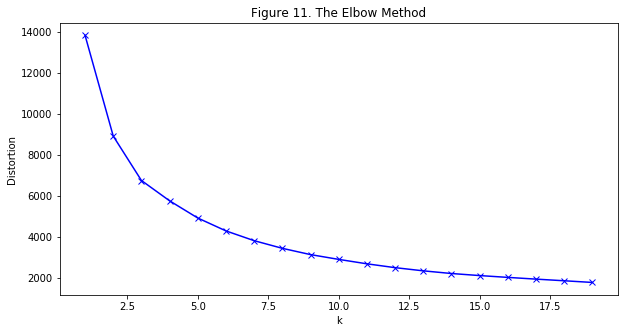

In [28]:
## elbow method plot

distortions = []

K = range(1,20)
for k in K:
    kmean = KMeans(n_clusters=k, random_state=0, n_init = 50, max_iter = 500)
    kmean.fit(X)
    distortions.append(kmean.inertia_)
    
plt.figure(figsize=(10,5))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Figure 11. The Elbow Method')
plt.show()

In [29]:
# run k-means clustering
kmeans = KMeans(n_clusters=4, random_state=0).fit(X)

df_new['Cluster'] = (kmeans.labels_).astype(str)
df_cluster = pd.merge(df_new[['AirportCode','Cluster']], weather.drop(['Cold','Hail'], axis=1), 
                      how='inner', on='AirportCode')
df_cluster.head()

AirportCode Cluster       Fog  Precipitation      Rain      Snow     Storm  \
0        K01M       3  1.787814       0.143312  5.922993  0.136416  0.000000   
1        K04V       2  0.078196       0.004994  1.384941  1.258086  0.042856   
2        K04W       0  1.531773       0.014032  3.533248  2.681554  0.000999   
3        K06D       0  1.670472       0.019026  1.421233  3.830860  0.087519   
4        K08D       0  3.593037       0.000000  1.165335  3.070776  0.018075   

       City State  LocationLat  LocationLng  
0   Belmont    MS      34.4917     -88.2011  
1  Saguache    CO      38.0972    -106.1689  
2  Hinckley    MN      46.0244     -92.8991  
3     Rolla    ND      48.8844     -99.6208  
4   Stanley    ND      48.3008    -102.4064

## K means clustering results on city-wide cluster distribution

## The city wide weather cluster is shown in Figure 12. We can see that cluster 2(green) is widely spread in the country whereas clusters 3(red), 1(blue), 0(yellow) have a clear boundary with each other.

In [30]:
fig_cluster = px.scatter_geo(df_cluster, lat='LocationLat', lon='LocationLng',
                      hover_name=weather['City'] + ', ' + weather['State'],
                      scope="usa",
                      color_discrete_sequence =['Red', 'Green', 'Yellow','Blue'],
                      color = 'Cluster',
                      title ='Figure 12. City wide weather cluster distribution')

fig_cluster.show()

## To better visualize clusters are grouped as state. Almost all states have mix type of clusters which is shown in Figure 13.

In [31]:
df_cluster2 = df_cluster.groupby(['State','Cluster']).agg({'Cluster':['count']}).reset_index()
df_cluster2.columns=pd.MultiIndex.from_tuples((("State", " "),("Cluster", " "),("Count", " ")))
df_cluster2.columns = df_cluster2.columns.get_level_values(0)
df_cluster2.tail(3)

State Cluster  Count
138    WY       0     24
139    WY       2     29
140    WY       3      1

In [32]:
df_loc = df_cluster[['State','Cluster','LocationLat', 'LocationLng']]
df_loc1 = df_loc.groupby(['State','Cluster']).agg({'LocationLat':'mean'}).reset_index()
df_loc2 = df_loc.groupby(['State','Cluster']).agg({'LocationLng':'mean'}).reset_index()
df_loc3 = pd.merge(df_loc1,df_loc2, how='inner', on=['State','Cluster'])
df_loc3.tail(3)

State Cluster  LocationLat  LocationLng
138    WY       0    42.895096  -107.586363
139    WY       2    42.574969  -107.297807
140    WY       3    41.725300  -106.459400

In [33]:
df_clusterA = pd.merge(df_loc3,df_cluster2, how='inner', on=['State','Cluster'])
df_clusterA.tail(3)

State Cluster  LocationLat  LocationLng  Count
138    WY       0    42.895096  -107.586363     24
139    WY       2    42.574969  -107.297807     29
140    WY       3    41.725300  -106.459400      1

In [34]:
figure_clusterA = px.scatter_geo(df_clusterA, lat='LocationLat', lon='LocationLng', 
                     color='Cluster',
                     size='Count',
                     color_discrete_sequence=['Red', 'Green', 'Yellow','Blue'],
                     hover_name='State',
                     scope="usa",
                     title = 'Figure 13. State wide weather cluster distribution')

In [35]:
figure_clusterA.show()

## Next we determine the property of clusters which is shown in Figure 14. Compared to other clusters, cluster 3(purple) has highest chances of rain, cluster 0(blue) has highest chances of snow and cluster 1(red) and cluster 3(purple) have highest chances of fog. 

In [36]:
## property of clusters.

prop = df_cluster[['Cluster', 'Fog',
                   'Precipitation','Rain', 'Snow', 'Storm']].groupby(['Cluster']).mean().reset_index()

In [37]:
prop

Cluster       Fog  Precipitation      Rain      Snow     Storm
0       0  1.711273       0.023248  3.660675  3.127956  0.067607
1       1  1.482137       0.063810  4.389395  0.315847  0.007746
2       2  0.953967       0.044628  1.603151  0.528320  0.062348
3       3  1.786674       0.042998  6.590654  1.179963  0.011134

In [38]:
prop2 = prop.transpose().reset_index()
prop2 = prop2[(prop2['index'] !='Cluster')].sort_values(by=0)
prop2

index          0           1          2          3
2  Precipitation  0.0232475     0.06381  0.0446281  0.0429976
5          Storm  0.0676072  0.00774602   0.062348  0.0111338
1            Fog    1.71127     1.48214   0.953967    1.78667
4           Snow    3.12796    0.315847    0.52832    1.17996
3           Rain    3.66067      4.3894    1.60315    6.59065

In [39]:
fig_prop=make_subplots(rows=1, cols=4, shared_yaxes=True,horizontal_spacing=0.05)

fig_prop.add_trace(go.Bar(x=prop2['index'], y=prop2[0], name='Cluster 0'), row=1, col=1)
fig_prop.add_trace(go.Bar(x=prop2['index'], y=prop2[1], name='Cluster 1'), row=1, col=2)
fig_prop.add_trace(go.Bar(x=prop2['index'], y=prop2[2], name='Cluster 2'), row=1, col=3)
fig_prop.add_trace(go.Bar(x=prop2['index'], y=prop2[3], name='Cluster 3'), row=1, col=4)

fig_prop.update_yaxes(title_text="duration%/year", row=1, col=1)
fig_prop.update_layout(title_text="Figure 14. Weather distribution in each cluster")

fig_prop.show()

## Representive cities in each cluster

### Four cities were selected in each cluster, Denver, CO is the representive city of clsuter 0; Detroit, MI is the representive city of cluster 1; Kansas City, MO is the representive city of cluster 2; Seattle, MA is the representive city of cluster 3. All the cities weather information are shown in Figure 15.

In [40]:
df2 = weather[(weather['City']=='Seattle')| (weather['City']=='Detroit')|(weather['City']== 'Kansas City')|(weather['City']== 'Denver')]
df2

AirportCode      Cold       Fog      Hail  Precipitation      Rain  \
267         KBFI  0.217513  0.890887  0.003520       0.007325  7.818874   
543         KDEN  0.012938  1.352454  0.005470       0.015649  1.886320   
545         KDET  0.058742  0.961806  0.000000       0.051608  4.708428   
591         KDTW  0.009275  3.462519  0.012462       0.041191  6.167047   
1235        KMCI  0.008562  1.153158  0.024686       0.098602  4.555841   
1282        KMKC  0.095225  0.552559  0.000000       0.074011  3.503995   
1404        KNKA  0.000000  0.141029  0.000000       0.061025  0.720082   
1759        KSEA  0.001760  1.477597  0.000000       0.019597  8.881802   

          Snow     Storm         City State  LocationLat  LocationLng  
267   0.353786  0.000000      Seattle    WA      47.5455    -122.3147  
543   2.345129  0.062833       Denver    CO      39.8466    -104.6562  
545   1.786387  0.000000      Detroit    MI      42.4073     -83.0089  
591   2.915240  0.012842      Detroit    MI      42.2314     -83.3308  
1235  1.106783  0.006944  Kansas City    MO      39.2972     -94.7306  
1282  0.653111  0.000238  Kansas City    MO      39.1209     -94.5972  
1404  0.121623  0.000000  Kansas City    MO      39.1167     -94.6000  
1759  0.435122  0.002521      Seattle    WA      47.4447    -122.3144

In [41]:
df3= df2[['Storm', 'Precipitation','Snow', 'Fog','Rain', 'City']].groupby('City').mean().reset_index()

In [42]:
df3

City     Storm  Precipitation      Snow       Fog      Rain
0       Denver  0.062833       0.015649  2.345129  1.352454  1.886320
1      Detroit  0.006421       0.046399  2.350813  2.212162  5.437738
2  Kansas City  0.002394       0.077879  0.627172  0.615582  2.926639
3      Seattle  0.001260       0.013461  0.394454  1.184242  8.350338

In [43]:
df3 = df3.transpose().reset_index()
df3

index          0           1            2           3
0           City     Denver     Detroit  Kansas City     Seattle
1          Storm   0.062833  0.00642123   0.00239409  0.00126046
2  Precipitation  0.0156488   0.0463994    0.0778792   0.0134608
3           Snow    2.34513     2.35081     0.627172    0.394454
4            Fog    1.35245     2.21216     0.615582     1.18424
5           Rain    1.88632     5.43774      2.92664     8.35034

In [44]:
df3.columns = df3.iloc[0]
df3 = df3[(df3['City'] !='City')]
df3

0           City     Denver     Detroit Kansas City     Seattle
1          Storm   0.062833  0.00642123  0.00239409  0.00126046
2  Precipitation  0.0156488   0.0463994   0.0778792   0.0134608
3           Snow    2.34513     2.35081    0.627172    0.394454
4            Fog    1.35245     2.21216    0.615582     1.18424
5           Rain    1.88632     5.43774     2.92664     8.35034

In [45]:
figure_city=make_subplots(rows=1, cols=4, shared_yaxes=True,horizontal_spacing=0.05)

figure_city.add_trace(go.Bar(x=df3['City'], y=df3['Denver'], name='Cluster0'), row=1, col=1)
figure_city.add_trace(go.Bar(x=df3['City'], y=df3['Detroit'], name='Cluster1'), row=1, col=2)
figure_city.add_trace(go.Bar(x=df3['City'], y=df3['Kansas City'], name='Cluster2'), row=1, col=3)
figure_city.add_trace(go.Bar(x=df3['City'], y=df3['Seattle'], name='Cluster3'), row=1, col=4)

figure_city['layout']['xaxis1'].update(title="Denver, CO")
figure_city['layout']['xaxis2'].update(title="Detroit, MI")
figure_city['layout']['xaxis3'].update(title="Kansas City, MO")
figure_city['layout']['xaxis4'].update(title="Seattle, WA")
figure_city.update_yaxes(title_text="duration%/year", row=1, col=1)
figure_city.update_layout(title_text="Figure 15. Representative cities in each cluster")

figure_city.show()

## Principle Component Analysis

### A way for obtaining a better understanding of the data is to visualize it. PCA allows us to find a low dimensional representation of high dimensional data such that it contains as much variation in data as possible.

### In order to visualize how are the clusters are related in the original high dimension space, PCA was applied to the original dataset. The cumulative variance explained for the first three component is able to cover more than 95% of the original information, therefore, reducing the dimensionality of the dataset (Figure 16 left). After mapping the cluster labels to the PCA dataset and visualize it in three dimensions (Figure 16 right), it showed that four cluster is reasonable to identify similar samples within the dataset.

In [46]:
pca = PCA().fit(X)
pca_X = pca.transform(X)
print("Variance explained by each component (%): ")
for i in range(len(pca.explained_variance_ratio_)):
      print("\n",i+1,"º:", pca.explained_variance_ratio_[i]*100)
print("Total sum (%): ",sum(pca.explained_variance_ratio_)*100)
print("Explained variance of the first two components (%): ",sum(pca.explained_variance_ratio_[0:1])*100)

Variance explained by each component (%): 

 1 º: 55.36131446590274

 2 º: 27.481349041430036

 3 º: 16.02278024027619

 4 º: 1.0162538007778663

 5 º: 0.11830245161318607
Total sum (%):  100.00000000000003
Explained variance of the first two components (%):  55.36131446590274


In [47]:
c0 = []
c1 = []
c2 = []
c3 = []

for i in range(len(pca_X)):
    if kmeans.labels_[i] == 0:
        c0.append(pca_X[i])
    if kmeans.labels_[i] == 1:
        c1.append(pca_X[i])
    if kmeans.labels_[i] == 2:
        c2.append(pca_X[i])
    if kmeans.labels_[i] == 3:
        c3.append(pca_X[i])
        
        
c0 = np.array(c0)
c1 = np.array(c1)
c2 = np.array(c2)
c3 = np.array(c3)

figure_pca = make_subplots(rows=1, cols=2, column_widths=[0.3, 0.7], specs=[[{'type':'domain'}, {'type': 'mesh3d'}]])

figure_pca.add_trace(go.Pie(values = pca.explained_variance_ratio_), row=1, col=1)

figure_pca.add_trace(go.Scatter3d(x=c0[:,0], y=c0[:,1], z=c0[:,2],
                               mode='markers', name='Cluster0'),  row=1, col=2)
figure_pca.add_trace(go.Scatter3d(x=c1[:,0], y=c1[:,1], z=c1[:,2], 
                               mode='markers', name='Cluster1'),  row=1, col=2)
figure_pca.add_trace(go.Scatter3d(x=c2[:,0], y=c2[:,1], z=c2[:,2], 
                               mode='markers', name='Cluster2'),  row=1, col=2)
figure_pca.add_trace(go.Scatter3d(x=c3[:,0], y=c3[:,1], z=c3[:,2], 
                               mode='markers', name='Cluster3'),  row=1, col=2)

figure_pca.update_layout(height=750, width=1000, title_text=
          "Figure 16. PCA: explained variance%(left) and First 3 Component with mapped cluster(right)")

figure_pca.show()

## Classification of Detroit's weather events

### Below we will be applying classification algorithms after splitting our data into test and train set. The coloumn 'Type' will be our target variable. 

### Firstly, we will filter the data for only Detroit's weather event, perform some visualisations and accordingly clean the data and perform the following algorithms and check the accuracy for each algorithms which will help us to determine the best features to classify weather events:

1. KNeighborsClassifier - k-Nearest-Neighbors (k-NN) is a supervised machine learning model. KNN model works by taking a data point and looking at the ‘k’ closest labeled data points.
2. DecisionTreeClassifier - Decision tree as the name says breaks the data into series i.e. as a series of yes/no questions asked about our data eventually leading to a predicted class.
3. RandomForestClassifier - Random forest is similar to decision tree but multiple decision trees together makes a random forest i.e. decision trees are building block of a random forest.
4. GradientBoostingClassifier - Boosting is a method of combining weak components into strong components. Gradient boosting begins by training a decision tree in which each component is assigned an equal weight. After evaluating the first tree, we increase the weights of those observations that are difficult to classify and lower the weights for those that are easy to classify. Gradient boosting performs using gradients in the loss function. 

In [48]:
Detroit = data[(data['City']== 'Detroit')]
print(Detroit['LocationLat'].unique())
print(Detroit['LocationLng'].unique())

[42.2314 42.4073]
[-83.3308 -83.0089]


In [49]:
Detroit.head(5)

EventId  Type  Severity       StartTime(UTC)         EndTime(UTC)  \
402854  W-454919   Fog  Moderate  2016-08-02 12:53:00  2016-08-02 13:53:00   
402855  W-454920   Fog  Moderate  2016-08-04 12:53:00  2016-08-04 14:53:00   
402856  W-454921   Fog  Moderate  2016-08-05 08:53:00  2016-08-05 13:53:00   
402857  W-454922  Rain     Light  2016-08-05 17:05:00  2016-08-05 17:28:00   
402858  W-454923  Rain  Moderate  2016-08-05 17:28:00  2016-08-05 17:53:00   

          TimeZone  LocationLat  LocationLng AirportCode     City County  \
402854  US/Eastern      42.2314     -83.3308        KDTW  Detroit  Wayne   
402855  US/Eastern      42.2314     -83.3308        KDTW  Detroit  Wayne   
402856  US/Eastern      42.2314     -83.3308        KDTW  Detroit  Wayne   
402857  US/Eastern      42.2314     -83.3308        KDTW  Detroit  Wayne   
402858  US/Eastern      42.2314     -83.3308        KDTW  Detroit  Wayne   

       State  ZipCode                 End               Start  Duration  
402854    MI  48242.0 2016-08-02 13:53:00 2016-08-02 12:53:00  1.000000  
402855    MI  48242.0 2016-08-04 14:53:00 2016-08-04 12:53:00  2.000000  
402856    MI  48242.0 2016-08-05 13:53:00 2016-08-05 08:53:00  5.000000  
402857    MI  48242.0 2016-08-05 17:28:00 2016-08-05 17:05:00  0.383333  
402858    MI  48242.0 2016-08-05 17:53:00 2016-08-05 17:28:00  0.416667

In [50]:
## Breaking both start time and end time columns into year, month, week, weekday, day columns.

Detroit['StartTime(UTC)'] = pd.to_datetime(Detroit['StartTime(UTC)'])
Detroit['EndTime(UTC)'] = pd.to_datetime(Detroit['EndTime(UTC)'])

Detroit['Start_year'] = Detroit['StartTime(UTC)'].dt.year
Detroit['Start_month'] = Detroit['StartTime(UTC)'].dt.month
Detroit['Start_week'] = Detroit['StartTime(UTC)'].dt.week
Detroit['Start_weekday'] = Detroit['StartTime(UTC)'].dt.weekday
Detroit['Start_day'] = Detroit['StartTime(UTC)'].dt.day

Detroit['end_year'] = Detroit['EndTime(UTC)'].dt.year
Detroit['end_month'] = Detroit['EndTime(UTC)'].dt.month
Detroit['end_week'] = Detroit['EndTime(UTC)'].dt.week
Detroit['end_weekday'] = Detroit['EndTime(UTC)'].dt.weekday
Detroit['end_day'] = Detroit['EndTime(UTC)'].dt.day

C:\Users\ararn\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\ararn\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\ararn\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/panda

In [51]:
Detroit.head(5)

EventId  Type  Severity      StartTime(UTC)        EndTime(UTC)  \
402854  W-454919   Fog  Moderate 2016-08-02 12:53:00 2016-08-02 13:53:00   
402855  W-454920   Fog  Moderate 2016-08-04 12:53:00 2016-08-04 14:53:00   
402856  W-454921   Fog  Moderate 2016-08-05 08:53:00 2016-08-05 13:53:00   
402857  W-454922  Rain     Light 2016-08-05 17:05:00 2016-08-05 17:28:00   
402858  W-454923  Rain  Moderate 2016-08-05 17:28:00 2016-08-05 17:53:00   

          TimeZone  LocationLat  LocationLng AirportCode     City  ...  \
402854  US/Eastern      42.2314     -83.3308        KDTW  Detroit  ...   
402855  US/Eastern      42.2314     -83.3308        KDTW  Detroit  ...   
402856  US/Eastern      42.2314     -83.3308        KDTW  Detroit  ...   
402857  US/Eastern      42.2314     -83.3308        KDTW  Detroit  ...   
402858  US/Eastern      42.2314     -83.3308        KDTW  Detroit  ...   

       Start_year Start_month  Start_week Start_weekday Start_day  end_year  \
402854       2016           8          31             1         2      2016   
402855       2016           8          31             3         4      2016   
402856       2016           8          31             4         5      2016   
402857       2016           8          31             4         5      2016   
402858       2016           8          31             4         5      2016   

        end_month  end_week  end_weekday  end_day  
402854          8        31            1        2  
402855          8        31            3        4  
402856          8        31            4        5  
402857          8        31            4        5  
402858          8        31            4        5  

[5 rows x 26 columns]

In [52]:
## dropping columns which are not needed for further analysis.

X2 = Detroit.drop(['StartTime(UTC)','EndTime(UTC)','EventId',
                   'TimeZone','LocationLat','LocationLng','AirportCode','ZipCode','End','Start'],axis = 1)

In [53]:
X2.head(5)

Type  Severity     City County State  Duration  Start_year  \
402854   Fog  Moderate  Detroit  Wayne    MI  1.000000        2016   
402855   Fog  Moderate  Detroit  Wayne    MI  2.000000        2016   
402856   Fog  Moderate  Detroit  Wayne    MI  5.000000        2016   
402857  Rain     Light  Detroit  Wayne    MI  0.383333        2016   
402858  Rain  Moderate  Detroit  Wayne    MI  0.416667        2016   

        Start_month  Start_week  Start_weekday  Start_day  end_year  \
402854            8          31              1          2      2016   
402855            8          31              3          4      2016   
402856            8          31              4          5      2016   
402857            8          31              4          5      2016   
402858            8          31              4          5      2016   

        end_month  end_week  end_weekday  end_day  
402854          8        31            1        2  
402855          8        31            3        4  
402856          8        31            4        5  
402857          8        31            4        5  
402858          8        31            4        5

In [54]:
## Dropping Severity 'Unknown' and 'other' as it has very less points.

X2 = X2[(X2['Severity'] != 'UNK') & (X2['Severity'] != 'Other')]

In [55]:
print(X2['Type'].unique())
print(X2['Severity'].unique())
print(X2['Type'].count())
print(X2['Severity'].count())

['Fog' 'Rain' 'Cold' 'Snow' 'Storm']
['Moderate' 'Light' 'Severe' 'Heavy']
4745
4745


In [56]:
print(X2['Start_week'].unique())

[31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52  1  2
  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26
 27 28 29 30]


In [57]:
## Encoding Rain as 0, Fog as 1, Snow and Cold as 2, Storm as 3. 

Type = {'Rain':0, 'Fog':1, 'Snow':2,'Cold':2, 'Storm':3 } 
X2.Type = [Type[item] for item in X2.Type]
X2.head(10)

Type  Severity     City County State  Duration  Start_year  \
402854     1  Moderate  Detroit  Wayne    MI  1.000000        2016   
402855     1  Moderate  Detroit  Wayne    MI  2.000000        2016   
402856     1  Moderate  Detroit  Wayne    MI  5.000000        2016   
402857     0     Light  Detroit  Wayne    MI  0.383333        2016   
402858     0  Moderate  Detroit  Wayne    MI  0.416667        2016   
402859     1  Moderate  Detroit  Wayne    MI  2.000000        2016   
402860     1  Moderate  Detroit  Wayne    MI  2.000000        2016   
402861     1  Moderate  Detroit  Wayne    MI  2.000000        2016   
402862     0     Light  Detroit  Wayne    MI  2.000000        2016   
402863     1  Moderate  Detroit  Wayne    MI  1.000000        2016   

        Start_month  Start_week  Start_weekday  Start_day  end_year  \
402854            8          31              1          2      2016   
402855            8          31              3          4      2016   
402856            8          31              4          5      2016   
402857            8          31              4          5      2016   
402858            8          31              4          5      2016   
402859            8          32              2         10      2016   
402860            8          32              3         11      2016   
402861            8          32              3         11      2016   
402862            8          32              3         11      2016   
402863            8          32              4         12      2016   

        end_month  end_week  end_weekday  end_day  
402854          8        31            1        2  
402855          8        31            3        4  
402856          8        31            4        5  
402857          8        31            4        5  
402858          8        31            4        5  
402859          8        32            2       10  
402860          8        32            3       11  
402861          8        32            3       11  
402862          8        32            3       11  
402863          8        32            4       12

In [58]:
X3 = X2.drop(['County','State','City'],axis =1 )
X3.head(10)

Type  Severity  Duration  Start_year  Start_month  Start_week  \
402854     1  Moderate  1.000000        2016            8          31   
402855     1  Moderate  2.000000        2016            8          31   
402856     1  Moderate  5.000000        2016            8          31   
402857     0     Light  0.383333        2016            8          31   
402858     0  Moderate  0.416667        2016            8          31   
402859     1  Moderate  2.000000        2016            8          32   
402860     1  Moderate  2.000000        2016            8          32   
402861     1  Moderate  2.000000        2016            8          32   
402862     0     Light  2.000000        2016            8          32   
402863     1  Moderate  1.000000        2016            8          32   

        Start_weekday  Start_day  end_year  end_month  end_week  end_weekday  \
402854              1          2      2016          8        31            1   
402855              3          4      2016          8        31            3   
402856              4          5      2016          8        31            4   
402857              4          5      2016          8        31            4   
402858              4          5      2016          8        31            4   
402859              2         10      2016          8        32            2   
402860              3         11      2016          8        32            3   
402861              3         11      2016          8        32            3   
402862              3         11      2016          8        32            3   
402863              4         12      2016          8        32            4   

        end_day  
402854        2  
402855        4  
402856        5  
402857        5  
402858        5  
402859       10  
402860       11  
402861       11  
402862       11  
402863       12

### Feature Engineering using the dummy feature of pandas which converts categorical variable into dummy/indicator variables. 

In [59]:
## we split 'Severity' into Heavy, Light, Moderate and Severe columns and then dropping the 'Severity' column.. 

X4 = pd.concat([X3,pd.get_dummies(X3['Severity'], prefix='Severity')],axis=1)
X4.head(5)

Type  Severity  Duration  Start_year  Start_month  Start_week  \
402854     1  Moderate  1.000000        2016            8          31   
402855     1  Moderate  2.000000        2016            8          31   
402856     1  Moderate  5.000000        2016            8          31   
402857     0     Light  0.383333        2016            8          31   
402858     0  Moderate  0.416667        2016            8          31   

        Start_weekday  Start_day  end_year  end_month  end_week  end_weekday  \
402854              1          2      2016          8        31            1   
402855              3          4      2016          8        31            3   
402856              4          5      2016          8        31            4   
402857              4          5      2016          8        31            4   
402858              4          5      2016          8        31            4   

        end_day  Severity_Heavy  Severity_Light  Severity_Moderate  \
402854        2               0               0                  1   
402855        4               0               0                  1   
402856        5               0               0                  1   
402857        5               0               1                  0   
402858        5               0               0                  1   

        Severity_Severe  
402854                0  
402855                0  
402856                0  
402857                0  
402858                0

In [60]:
X4.drop(['Severity'],axis=1, inplace=True)

In [61]:
data_norm = X4

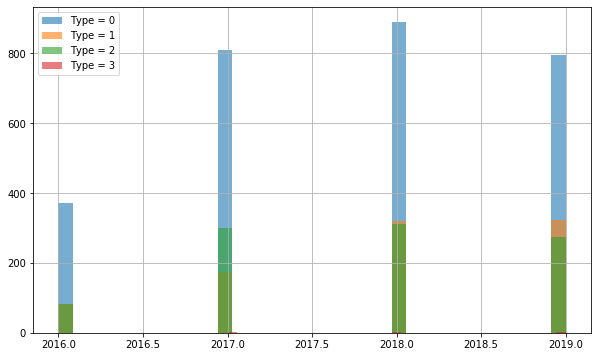

In [62]:
## Below plot shows the occurance of weather event in every year. 

plt.figure(figsize = (10,6))
data_norm[data_norm['Type']==0]['Start_year'].hist(bins = 35, label = 'Type = 0', alpha =0.6)
data_norm[data_norm['Type']==1]['Start_year'].hist(bins = 35, label = 'Type = 1',alpha =0.6)
data_norm[data_norm['Type']==2]['Start_year'].hist(bins = 35, label = 'Type = 2',alpha =0.6)
data_norm[data_norm['Type']==3]['Start_year'].hist(bins = 35, label = 'Type = 3',alpha =0.6)

plt.legend()

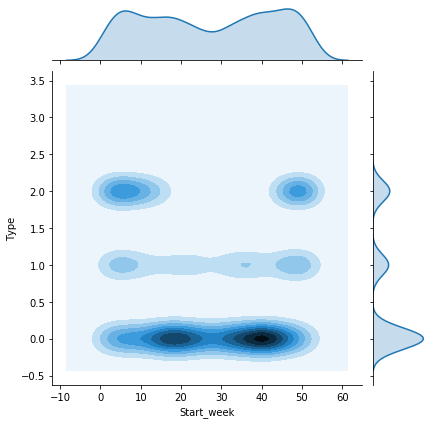

In [63]:
## Below plot shows the occurance of weather event in weekly basis. We can see that the data is pretty scattered from 1st week to 55th week.

sns.jointplot(x = 'Start_week', y = 'Type', data = data_norm, kind = 'kde')

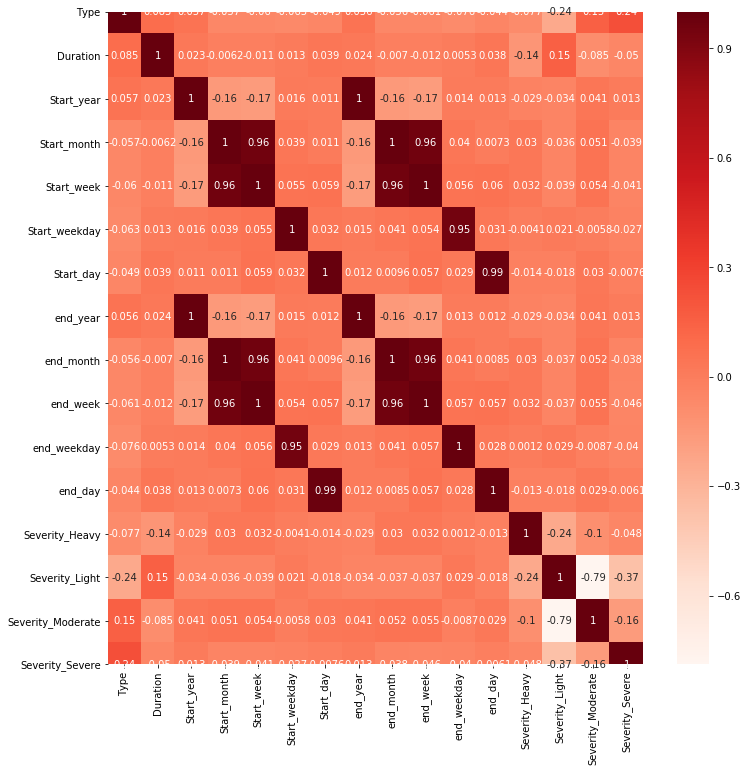

In [64]:
## heatmap for correlations between features

plt.figure(figsize=(12, 12))
cor = data_norm.corr(method="spearman")
sns.heatmap(cor, annot=True, xticklabels=True, cmap=plt.cm.Reds)
plt.show()

In [65]:
## We drop some of the columns, as few columns have the exat same correlation as shown in the above heatmap.

data_final = data_norm.drop(['end_year','end_month','end_week', 'end_weekday', 'end_day'],axis =1 )

In [66]:
data_final.head(5)

Type  Duration  Start_year  Start_month  Start_week  Start_weekday  \
402854     1  1.000000        2016            8          31              1   
402855     1  2.000000        2016            8          31              3   
402856     1  5.000000        2016            8          31              4   
402857     0  0.383333        2016            8          31              4   
402858     0  0.416667        2016            8          31              4   

        Start_day  Severity_Heavy  Severity_Light  Severity_Moderate  \
402854          2               0               0                  1   
402855          4               0               0                  1   
402856          5               0               0                  1   
402857          5               0               1                  0   
402858          5               0               0                  1   

        Severity_Severe  
402854                0  
402855                0  
402856                0  
402857                0  
402858                0

In [67]:
data_final.shape

(4745, 11)

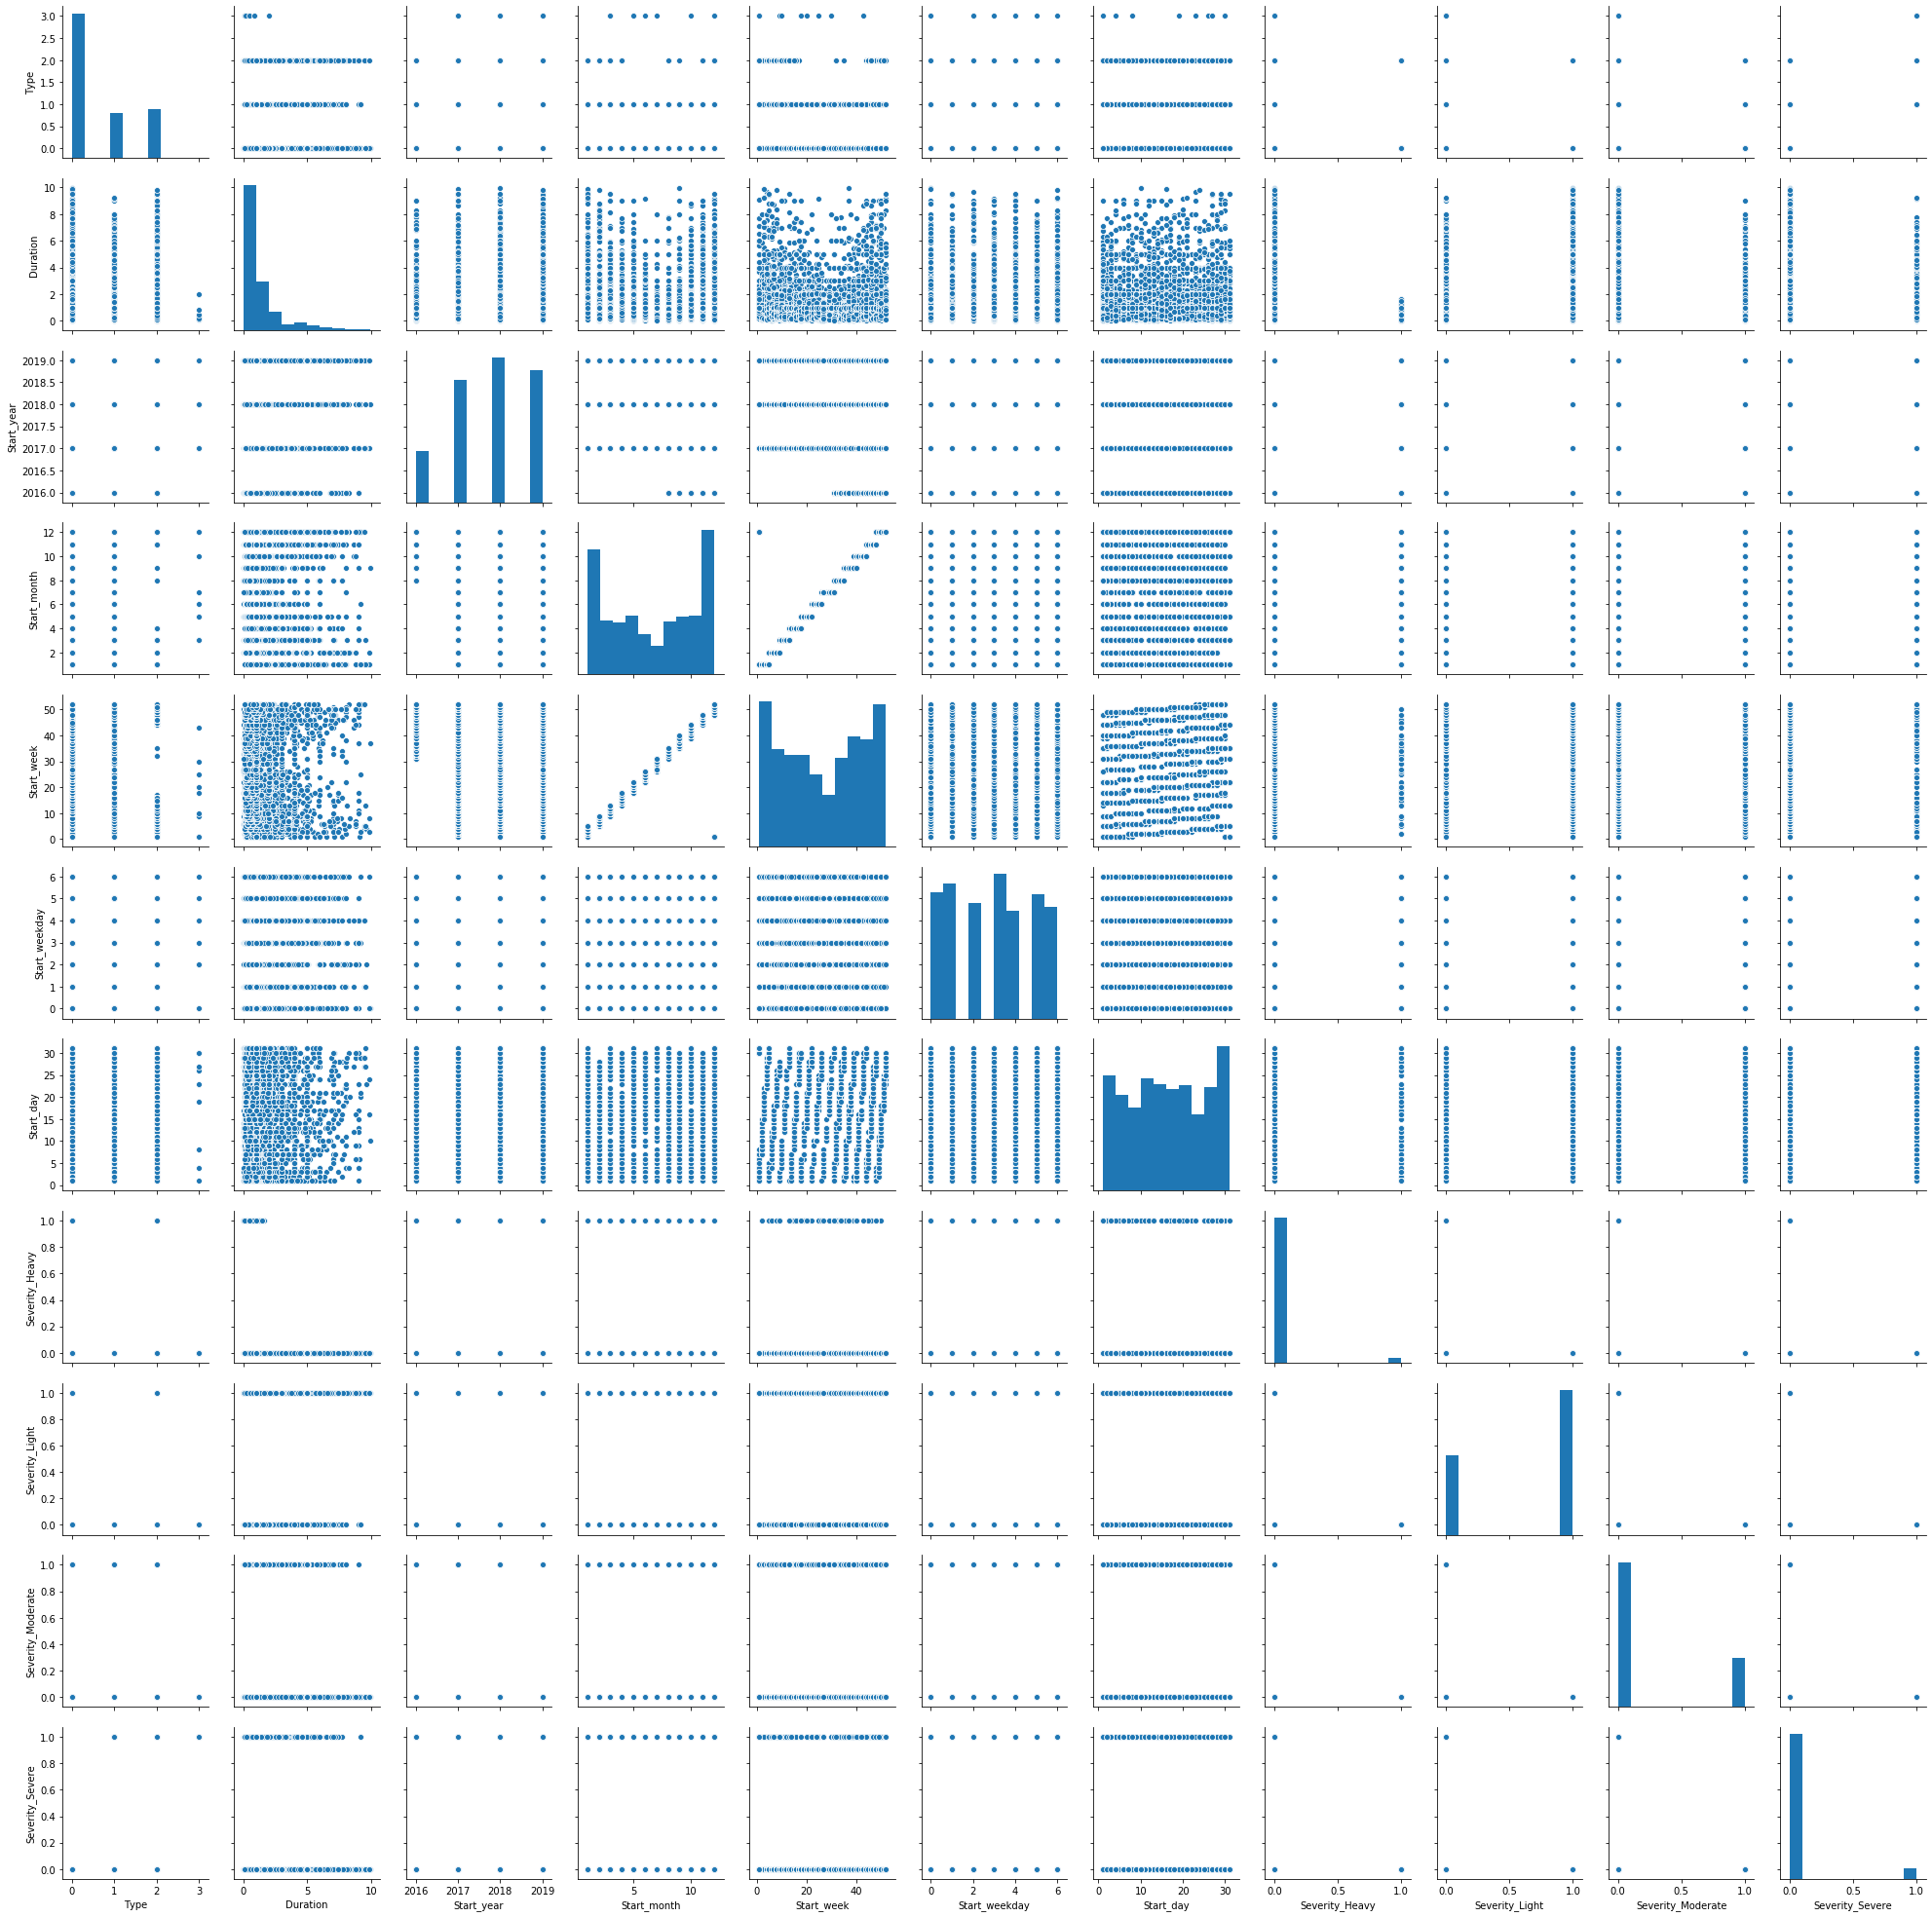

In [68]:
##  A pairplot plots a pairwise relationships in a dataset between all the features.

sns.pairplot(data_final, palette='Set1')

#### Below we tried to check the outliers using the boxplot but since there isn't much outliers, we keep it as it is.

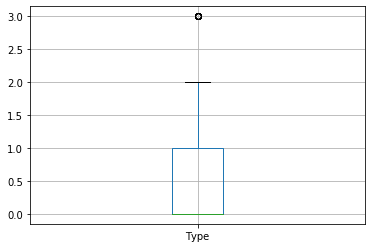

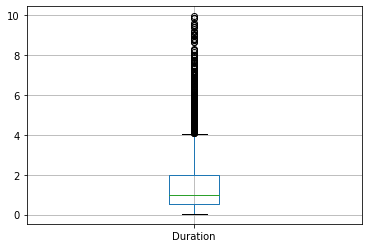

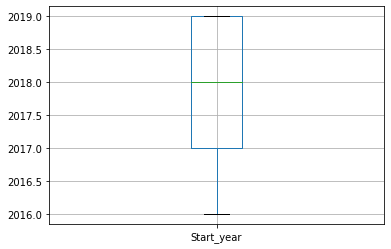

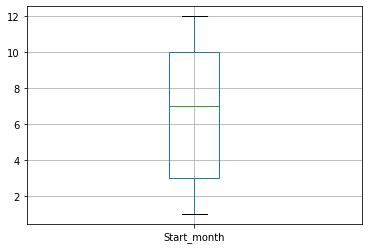

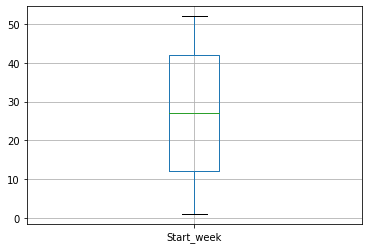

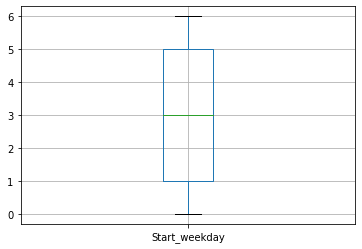

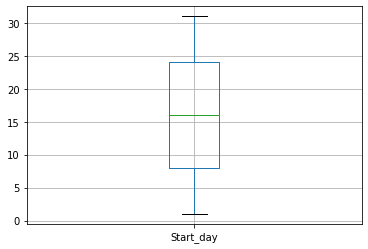

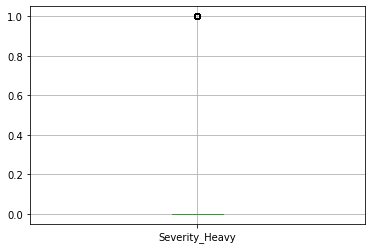

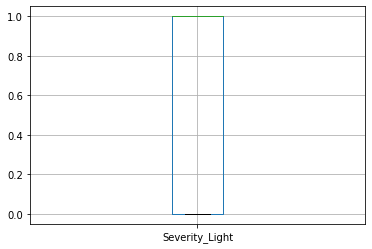

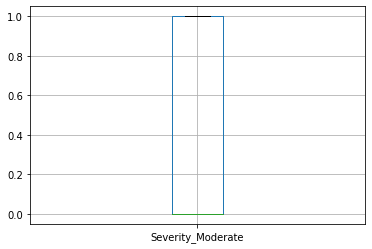

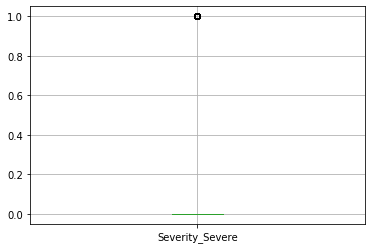

In [69]:
for column in data_final.columns:
    #print(column)
    plt.figure()
    data_final.boxplot([column])

#### We consider 'Type' as 'y' variable and the rest features as 'x' variable and then split our data into 70%-30%. 

In [70]:
y = data_final.Type
x = data_final.drop('Type', axis=1)

print('Target dimentions: ',y.shape)
print('Independent data dimentions: ',x.shape)

import sklearn.model_selection as model_selection
x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, train_size=0.7,test_size=0.3, random_state=101)

#splitting data into 70-30% size ratio.

print('x_train dimentions: ',x_train.shape)
print('y_train  dimentions: ',y_train.shape)
print('x_test dimentions: ',x_test.shape)
print('y_test  dimentions: ',y_test.shape)

# As all dimentions are correct, we can move towards model creation, training and testing

Target dimentions:  (4745,)
Independent data dimentions:  (4745, 10)
x_train dimentions:  (3321, 10)
y_train  dimentions:  (3321,)
x_test dimentions:  (1424, 10)
y_test  dimentions:  (1424,)


## Applying KNN, DecisionTree, RandomForest, GradientBoosting

In [71]:
classifiers = [
    KNeighborsClassifier(3),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    GradientBoostingClassifier(),
    ]

# Logging for Visual Comparison
log_cols=["Classifier", "Accuracy", "Log Loss"]
log = pd.DataFrame(columns=log_cols)

In [72]:
## creating for loop and printing the results for all the classifiers.

for clf in classifiers:
    clf.fit(x_train, y_train)
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    
    print('****Results****')
    train_predictions = clf.predict(x_test)
    acc = accuracy_score(y_test, train_predictions)
    
    print("Accuracy: {:.4%}".format(acc))
    print('*************')
    
    print(classification_report(y_test, train_predictions))
    
print("="*30)

KNeighborsClassifier
****Results****
Accuracy: 82.3736%
*************
              precision    recall  f1-score   support

           0       0.84      0.93      0.88       858
           1       0.81      0.49      0.61       269
           2       0.78      0.80      0.79       296
           3       0.00      0.00      0.00         1

    accuracy                           0.82      1424
   macro avg       0.61      0.56      0.57      1424
weighted avg       0.82      0.82      0.81      1424

DecisionTreeClassifier
****Results****
Accuracy: 86.1657%
*************
              precision    recall  f1-score   support

           0       0.91      0.90      0.90       858
           1       0.81      0.82      0.81       269
           2       0.79      0.78      0.79       296
           3       0.25      1.00      0.40         1

    accuracy                           0.86      1424
   macro avg       0.69      0.88      0.73      1424
weighted avg       0.86      0.86      0.86

C:\Users\ararn\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.

C:\Users\ararn\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

C:\Users\ararn\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.



GradientBoostingClassifier
****Results****
Accuracy: 86.1657%
*************
              precision    recall  f1-score   support

           0       0.90      0.91      0.90       858
           1       0.83      0.84      0.84       269
           2       0.77      0.75      0.76       296
           3       1.00      1.00      1.00         1

    accuracy                           0.86      1424
   macro avg       0.88      0.87      0.88      1424
weighted avg       0.86      0.86      0.86      1424



### From the above algorithms, Random forest performs the best with the accuracy of 88.1320% as compared to others. 

### Below we try to improve the random forest algorithm by changing few features to get a better accuracy.

### We see a slight change, making the accuracy 89.40%.

In [73]:
## adding few more features to random forest classifier model

clf = RandomForestClassifier(n_estimators = 400,min_samples_split = 2,min_samples_leaf = 1,max_features= 'sqrt',max_depth =None,bootstrap= False)
clf.fit(x_train, y_train)

predictions = clf.predict(x_test)

In [74]:
accuracy_score(predictions,y_test)

0.8939606741573034

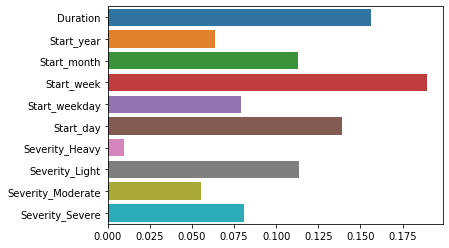

In [75]:
## plot of feature importance

ax = sns.barplot(x=clf.feature_importances_, y=x.columns)

## Among different classification technique Random Forest Classifier provides the best accuracy of around 89.40% with duration and week period as the most important features for Detroit City. Similarly we can do the same for different cities and check the important features.

## The main motive towards the assessment was to cover all the questionnaires using both clustering and classification machine learning technique. 